In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.python.keras._impl.keras.layers import Input
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.python.keras.layers import (Activation, Conv2D, Dense, Dropout, Flatten,
                                            MaxPool2D)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import datetime

/home/mandark/.conda/envs/py36tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
BATCH_SIZE = 256
EPOCHS = 27
PATIENCE = 50
LEARNING_RATE = 0.001
now = str(datetime.datetime.now())
CHECKPOINT_NAME = '_'.join(('checkpoint ' + now).split(' '))
print(CHECKPOINT_NAME)


checkpoint_2018-03-21_17:02:34.330492


Read data and add it to a csv

In [3]:
def load_data(test=False, mode=0, rgb=False):
    files = ['fer2013/training.csv',
             'fer2013/publictest.csv',
             'fer2013/privatetest.csv']
    
    data = pd.read_csv(files[mode])
    
    data['pixels'] = data['pixels'].apply(lambda img: np.fromstring(img, sep=' '))
    X = np.vstack(data['pixels'].values)
    # #normalize data
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    if rgb: # transform data cu rgb if needed
        X = cv2.cvtColor(data['pixels'], cv2.COLOR_GRAY2RGB)
        X = X.reshape(-1, 48, 48, 3)
    else:
        X = X.reshape(-1, 48, 48, 1)

    print(X.shape)
    
    if not test:
        y = data['emotion'].values
        y = y.astype(np.int)
        y = to_categorical(y)
    else:
        y = None

    return X, y


In [4]:
checkpointer = ModelCheckpoint(filepath='checkpoints/{0}.h5'.format(CHECKPOINT_NAME), verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=BATCH_SIZE, write_images=True)

model_callbacks = [checkpointer, early_stop, tensorboard]

In [6]:
from tensorflow.python.keras._impl.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(64, 3, input_shape=(48, 48, 1), activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()

optimizer = Adam(lr=0.01)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 19, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 17, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 32)        9248      
__________

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
X,y = load_data(mode=0)
X_validation, y_validation = load_data(mode=1)
hist = model.fit(X, y, shuffle=True, epochs=EPOCHS, batch_size=BATCH_SIZE,
                 callbacks=model_callbacks, verbose=1,
                 validation_data=(X_validation, y_validation))

(28709, 48, 48, 1)


(3589, 48, 48, 1)


Train on 28709 samples, validate on 3589 samples


Epoch 1/27


  256/28709 [..............................]  256/28709 [..............................] - ETA: 8:10 - loss: 1.9584 - acc: 0.0977

  512/28709 [..............................]  512/28709 [..............................] - ETA: 8:27 - loss: 1.9483 - acc: 0.1387

  768/28709 [..............................]  768/28709 [..............................] - ETA: 8:36 - loss: 1.9385 - acc: 0.1562

 1024/28709 [>.............................] 1024/28709 [>.............................] - ETA: 8:30 - loss: 1.9315 - acc: 0.1660

 1280/28709 [>.............................] 1280/28709 [>.............................] - ETA: 8:27 - loss: 1.9153 - acc: 0.1828

 1536/28709 [>.............................] 1536/28709 [>.............................] - ETA: 8:19 - loss: 1.9165 - acc: 0.1829

 1792/28709 [>.............................] 1792/28709 [>.............................] - ETA: 8:13 - loss: 1.9060 - acc: 0.1897

 2048/28709 [=>............................] 2048/28709 [=>............................] - ETA: 8:09 - loss: 1.8964 - acc: 0.1978

KeyboardInterrupt: 

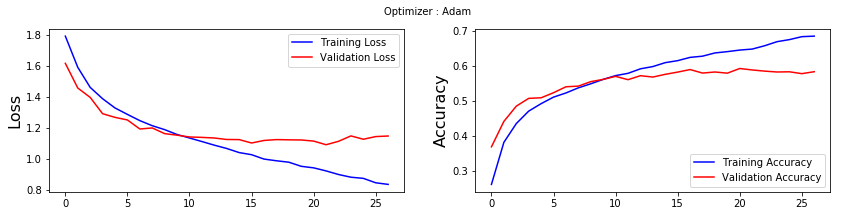

In [9]:
plt.figure(figsize=(14, 3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], 'b', label='Training Loss')
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [15]:
x_eval, y_eval = load_data(mode=2)

score = model.evaluate(x_eval, y_eval, verbose=1)
print('Score : ', score[0])
print('Accuracy : ', score[1] * 100)
model.save_weights('models/{0}.h5'.format(CHECKPOINT_NAME))

(3589, 48, 48, 1)
  32/3589 [..............................]  32/3589 [..............................] - ETA: 1s

 128/3589 [>.............................] 128/3589 [>.............................] - ETA: 1s

 224/3589 [>.............................] 224/3589 [>.............................] - ETA: 1s

 320/3589 [=>............................] 320/3589 [=>............................] - ETA: 1s

 416/3589 [==>...........................] 416/3589 [==>...........................] - ETA: 1s

 512/3589 [===>..........................] 512/3589 [===>..........................] - ETA: 1s

 608/3589 [====>.........................] 608/3589 [====>.........................] - ETA: 1s

 704/3589 [====>.........................] 704/3589 [====>.........................] - ETA: 1s

 800/3589 [=====>........................] 800/3589 [=====>........................] - ETA: 1s

 896/3589 [======>.......................] 896/3589 [======>.......................] - ETA: 1s

1024/3589 [=======>......................]1024/3589 [=======>......................] - ETA: 1s

1120/3589 [========>.....................]1120/3589 [========>.....................] - ETA: 1s

1216/3589 [=========>....................]1216/3589 [=========>....................] - ETA: 1s

1312/3589 [=========>....................]1312/3589 [=========>....................] - ETA: 1s

1408/3589 [==========>...................]1408/3589 [==========>...................] - ETA: 1s

1504/3589 [===========>..................]1504/3589 [===========>..................] - ETA: 1s

1600/3589 [============>.................]1600/3589 [============>.................] - ETA: 1s

1696/3589 [=============>................]1696/3589 [=============>................] - ETA: 1s

1792/3589 [=============>................]1792/3589 [=============>................] - ETA: 0s

1888/3589 [==============>...............]1888/3589 [==============>...............] - ETA: 0s

1984/3589 [===============>..............]1984/3589 [===============>..............] - ETA: 0s

2080/3589 [================>.............]2080/3589 [================>.............] - ETA: 0s

2176/3589 [=================>............]2176/3589 [=================>............] - ETA: 0s

2272/3589 [=================>............]2272/3589 [=================>............] - ETA: 0s

2368/3589 [==================>...........]2368/3589 [==================>...........] - ETA: 0s

2464/3589 [===================>..........]2464/3589 [===================>..........] - ETA: 0s

2560/3589 [====================>.........]2560/3589 [====================>.........] - ETA: 0s

2656/3589 [=====================>........]2656/3589 [=====================>........] - ETA: 0s

2752/3589 [======================>.......]2752/3589 [======================>.......] - ETA: 0s

2848/3589 [======================>.......]2848/3589 [======================>.......] - ETA: 0s

2944/3589 [=======================>......]2944/3589 [=======================>......] - ETA: 0s

3040/3589 [========================>.....]3040/3589 [========================>.....] - ETA: 0s

3136/3589 [=========================>....]3136/3589 [=========================>....] - ETA: 0s

3232/3589 [==========================>...]3232/3589 [==========================>...] - ETA: 0s

3328/3589 [==========================>...]3328/3589 [==========================>...] - ETA: 0s

3424/3589 [===========================>..]3424/3589 [===========================>..] - ETA: 0s

3520/3589 [============================>.]3520/3589 [============================>.] - ETA: 0s

3589/3589 [==============================]3589/3589 [==============================] - 2s 540us/step



Score :  1.0786776339054507
Accuracy :  59.40373363385927


In [17]:
x_eval, y_eval = load_data(mode=2)
model.load_weights('checkpoints/{0}.h5'.format(CHECKPOINT_NAME))

score = model.evaluate(x_eval, y_eval, verbose=1)
print('Score : ', score[0])
print('Accuracy : ', score[1] * 100)

(3589, 48, 48, 1)
  32/3589 [..............................]  32/3589 [..............................] - ETA: 1s

 128/3589 [>.............................] 128/3589 [>.............................] - ETA: 1s

 224/3589 [>.............................] 224/3589 [>.............................] - ETA: 1s

 320/3589 [=>............................] 320/3589 [=>............................] - ETA: 1s

 416/3589 [==>...........................] 416/3589 [==>...........................] - ETA: 1s

 512/3589 [===>..........................] 512/3589 [===>..........................] - ETA: 1s

 608/3589 [====>.........................] 608/3589 [====>.........................] - ETA: 1s

 704/3589 [====>.........................] 704/3589 [====>.........................] - ETA: 1s

 800/3589 [=====>........................] 800/3589 [=====>........................] - ETA: 1s

 896/3589 [======>.......................] 896/3589 [======>.......................] - ETA: 1s

 992/3589 [=======>......................] 992/3589 [=======>......................] - ETA: 1s

1088/3589 [========>.....................]1088/3589 [========>.....................] - ETA: 1s

1184/3589 [========>.....................]1184/3589 [========>.....................] - ETA: 1s

1280/3589 [=========>....................]1280/3589 [=========>....................] - ETA: 1s

1376/3589 [==========>...................]1376/3589 [==========>...................] - ETA: 1s

1472/3589 [===========>..................]1472/3589 [===========>..................] - ETA: 1s

1568/3589 [============>.................]1568/3589 [============>.................] - ETA: 1s

1664/3589 [============>.................]1664/3589 [============>.................] - ETA: 1s

1760/3589 [=============>................]1760/3589 [=============>................] - ETA: 0s

1856/3589 [==============>...............]1856/3589 [==============>...............] - ETA: 0s

1952/3589 [===============>..............]1952/3589 [===============>..............] - ETA: 0s

2048/3589 [================>.............]2048/3589 [================>.............] - ETA: 0s

2144/3589 [================>.............]2144/3589 [================>.............] - ETA: 0s

2240/3589 [=================>............]2240/3589 [=================>............] - ETA: 0s

2336/3589 [==================>...........]2336/3589 [==================>...........] - ETA: 0s

2432/3589 [===================>..........]2432/3589 [===================>..........] - ETA: 0s

2528/3589 [====================>.........]2528/3589 [====================>.........] - ETA: 0s

2624/3589 [====================>.........]2624/3589 [====================>.........] - ETA: 0s

2720/3589 [=====================>........]2720/3589 [=====================>........] - ETA: 0s

2816/3589 [======================>.......]2816/3589 [======================>.......] - ETA: 0s

2912/3589 [=======================>......]2912/3589 [=======================>......] - ETA: 0s

3008/3589 [========================>.....]3008/3589 [========================>.....] - ETA: 0s

3104/3589 [========================>.....]3104/3589 [========================>.....] - ETA: 0s

3200/3589 [=========================>....]3200/3589 [=========================>....] - ETA: 0s

3296/3589 [==========================>...]3296/3589 [==========================>...] - ETA: 0s

3392/3589 [===========================>..]3392/3589 [===========================>..] - ETA: 0s

3488/3589 [============================>.]3488/3589 [============================>.] - ETA: 0s

3584/3589 [============================>.]3584/3589 [============================>.] - ETA: 0s

3589/3589 [==============================]3589/3589 [==============================] - 2s 544us/step



Score :  1.0786776339054507
Accuracy :  59.40373363385927
